In [1]:
import pandas as pd
import librosa
from pathlib import Path
import torchaudio
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
from tqdm import tqdm
import numpy as np

In [2]:
df = pd.read_csv("cv-corpus-18.0-delta-2024-06-14-th/cv-corpus-18.0-delta-2024-06-14/th/other.tsv", sep='\t')
df = df[["path", "sentence"]]
df.head()

,path,sentence
0,common_voice_th_40196204.mp3,ดีใจเป็นอย่างยิ่ง
1,common_voice_th_40196205.mp3,เธอกำลังลงไปผับคืนนี้ใช่ไหมที่รัก ?
2,common_voice_th_40196206.mp3,ตอนนี้ใส่เสื้อแบบไม่ต้องรีด แต่แอบพังง่าย
3,common_voice_th_40196207.mp3,เข้าพักโรงแรมเขาก็ขอทำสำเนา
4,common_voice_th_40196208.mp3,สมัยนี้มีใช้สกิล แทน


In [3]:
clip_path = "cv-corpus-18.0-delta-2024-06-14-th/cv-corpus-18.0-delta-2024-06-14/th/clips/"

def get_data(df):
    wavs = []
    sample_rates = []
    sentences = []
    process = tqdm(range(len(df)))
    for index, row in df.iterrows():
        path = os.path.join(clip_path, row["path"])
        
        waveform, sample_rate = torchaudio.load(path)
        wavs.append(waveform)
        sample_rates.append(sample_rate)
        sentences.append(row["sentence"])
        process.update(1)
    
    return wavs, sample_rates, sentences, index

wavs, sample_rates, sentences, data_range = get_data(df)

100%|██████████| 613/613 [00:07<00:00, 86.43it/s] 


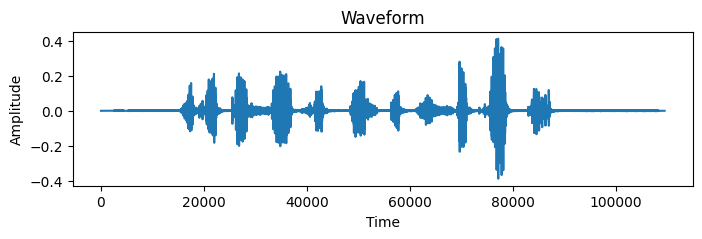

Sample rate: 32000
วิธีตรวจสอบสิทธิ์เงินอุดหนุนเด็กแรกเกิด


In [9]:
idx = 500

plt.figure(figsize=(8,2))
plt.title("Waveform")
plt.plot(wavs[idx].squeeze(0).detach().cpu().numpy())
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

print(f"Sample rate: {sample_rates[idx]}")
print(sentences[idx])
ipd.Audio(wavs[idx].squeeze(0).detach().cpu().numpy(), rate=sample_rates[idx])

In [10]:
spec_transform  = torchaudio.transforms.MelSpectrogram(
    n_fft=2048,
    win_length=2048//2,
    hop_length=2048//8,
    power=2
)

In [11]:
wav_mel = spec_transform(wavs[0])

wavs_mel = [spec_transform(wav) for wav in tqdm(wavs)]

100%|██████████| 613/613 [00:02<00:00, 274.90it/s]


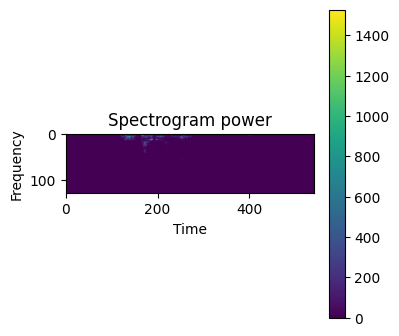

In [12]:
fig, (ax1) = plt.subplots(figsize=(4, 4), ncols=1)

_ = ax1.set_title("Spectrogram power")
pos = ax1.imshow(wavs_mel[0].squeeze(0).detach().cpu().numpy())
_ = fig.colorbar(pos, ax=ax1)

_ = ax1.set_xlabel("Time")
_ = ax1.set_ylabel("Frequency")

In [13]:
import math

def pow_mel_to_db(x):
    x = x[0]
    mel_spec = torchaudio.functional.amplitude_to_DB(
        x,
        multiplier = 10, 
        amin = 1e-10, 
        db_multiplier = math.log10(max(1e-10, x.max())),
        top_db = 80
    )
    
    mel_spec = mel_spec/10
    
    
    return mel_spec
    

In [14]:
db_mel_spec = pow_mel_to_db(wavs_mel[0])

db_mel_specs = [pow_mel_to_db(mel_spec) for mel_spec in tqdm(wavs_mel)]

  0%|          | 0/613 [00:00<?, ?it/s]

100%|██████████| 613/613 [00:00<00:00, 2720.62it/s]


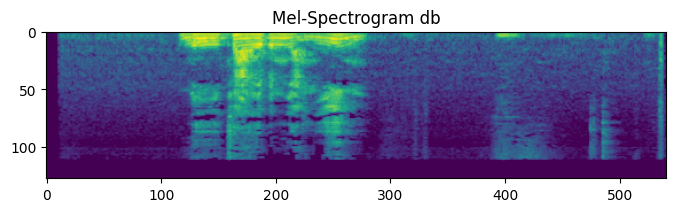

In [15]:
fig, (ax1) = plt.subplots(figsize=(8, 3), ncols=1)
_ = ax1.set_title("Mel-Spectrogram db")
pos = ax1.imshow(db_mel_specs[0].squeeze())
plt.show()

In [17]:
ipd.Audio(wavs[0].squeeze(0).detach().cpu().numpy(), rate=32000)

In [20]:
def show_spectrogram(idx):
    fig, ax = plt.subplots(figsize=(8, 9), ncols=1, nrows=3, gridspec_kw={'hspace': 0.4})  # Increased the height and adjusted hspace
    ax[0].set_title("Waveform")
    ax[0].plot(wavs[idx].squeeze(0).detach().cpu().numpy())
    ax[1].set_title("Spectrogram")
    ax[1].imshow(wavs_mel[idx].squeeze(0).detach().cpu().numpy(), aspect='auto')  # Ensure the aspect ratio is auto
    ax[2].set_title("Mel-Spectrogram db")
    ax[2].imshow(db_mel_specs[idx].squeeze(0).detach().cpu().numpy(), aspect='auto')  # Ensure the aspect ratio is auto
    
    print(sentences[idx])
    plt.show()

น่าจะคิดกันมาแล้ว อันนี้รอดูว่ายังไงต่อ ดูฉลาดไปผิดทางมาก


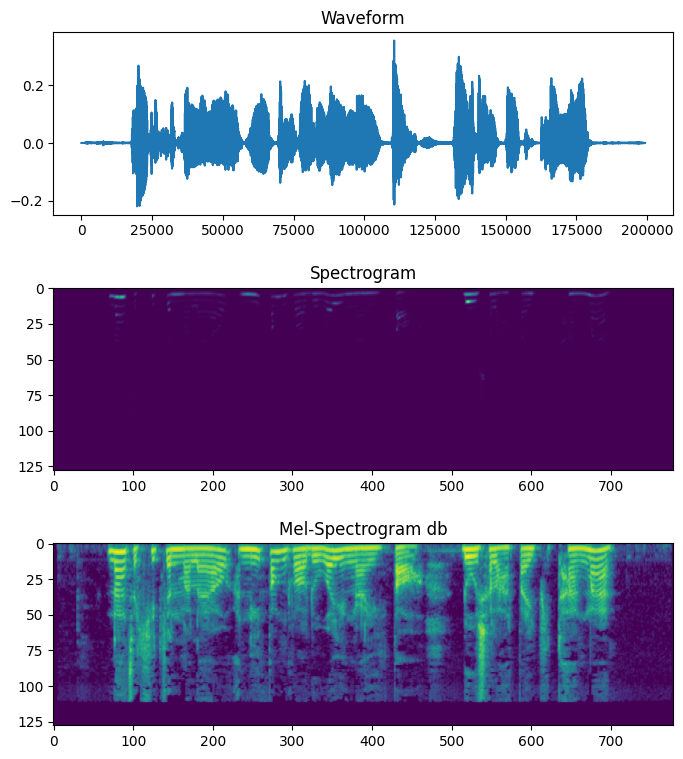

In [23]:
show_spectrogram(30)

In [113]:
# tokenizer pythainlp/thaig2p-v2.0

In [24]:
from tltk import g2p

In [38]:
text = g2p("สวัสดีครับ ชมรมคนชอบหมี")
text

"สวัส~ดี|ครับ<tr/>sa1'wat1~dii0|khrap3|<s/>ชม~รม|คน|ชอบ|หมี<tr/>chom0~rom0|khon0|chOOp2|mii4|<s/>"

In [46]:
import re

pattern = r"<tr\/>.*<s\/>"
matches = re.findall(pattern, text)

for match in matches:
    print(match)

<tr/>sa1'wat1~dii0|khrap3|<s/>ชม~รม|คน|ชอบ|หมี<tr/>chom0~rom0|khon0|chOOp2|mii4|<s/>


In [88]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda"

tokenizer = AutoTokenizer.from_pretrained("pythainlp/thaig2p-v2.0")
model = AutoModelForSeq2SeqLM.from_pretrained("pythainlp/thaig2p-v2.0").to(device)

In [92]:
text = "สวัสดีครับ วันนี้ผมจะมาสอนทำอาหาร"
token = tokenizer(text, return_tensors="pt").to(device)

In [93]:
tokenizer.batch_decode(model.generate(**token))[0].split(".")

['<pad> s a ˨˩',
 ' w a t̚ ˨˩',
 ' d i ˨˩',
 ' kh aː p̚ ˥˩',
 ' w a n ˧',
 ' n aː ˥˩',
 ' s aː ˩˩˦',
 ' ph o m ˧',
 ' m a n ˧</s>']

In [106]:
output = model.generate(**token,
                        num_beams=5,
                        max_length=256,
                        early_stopping=True)

In [107]:
tokenizer.batch_decode(output)

['<pad> s a ˨˩. w a t̚ ˨˩. d i ˨˩. kh aː p̚ ˥˩. w a n ˧. n aː ˥˩. s aː ˩˩˦. ph o m ˧. m a n ˧</s>']

In [109]:
from tltk import g2p

In [110]:
g2p(text)

"สวัส~ดี|ครับ<tr/>sa1'wat1~dii0|khrap3|<s/>วัน~นี้|ผม|จะ|มา|สอน|ทำ~อา~หาร<tr/>wan0~nii3|phom4|ca1|maa0|sOOn4|tham0~?aa0~haan4|<s/>"

In [113]:
g2p(text)

"สวัส~ดี|ครับ<tr/>sa1'wat1~dii0|khrap3|<s/>วัน~นี้|ผม|จะ|มา|สอน|ทำ~อา~หาร<tr/>wan0~nii3|phom4|ca1|maa0|sOOn4|tham0~?aa0~haan4|<s/>"